In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Class 19: Decisions and Uncertainty

# Another example of Multiple Categories: Benford's Law

[Benford’s Law](https://en.wikipedia.org/wiki/Benford%27s_law), also known as the Law of First Digits or the Phenomenon of Significant Digits, refers to the observation that the first digits (or numerals to be exact) of the numbers found in series of records of the most varied sources do not display a uniform distribution, but rather are arranged in such a way that the digit “1” is the most frequent, followed by “2”, “3”, and so in a successively decreasing manner down to “9”.

A set of numbers is said to satisfy Benford's law if the leading digit $d(d \in\{1, \ldots, 9\})$ occurs with probability(or proportion or distribution) given by the formula: $\log _{10}\left(1+\frac{1}{d}\right)$

As data scientist, we take this to be a model of the expected frequencies of the digits 1,...,9. we can take any record of numbers, say on a document and compare it to the distribution proposed by benford's law.

- We begin by using the Benford model formula above to generate the expected model proportions of each of the digits 1,...,9. 
- Then we follow with a visualization of the model/expected frequencies of each digit.


In [2]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)

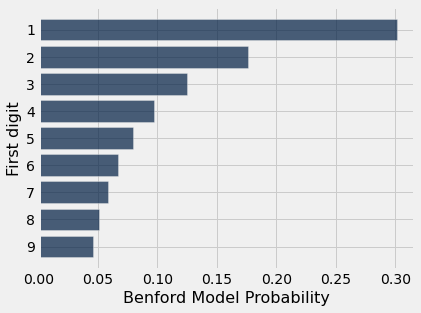

In [3]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford Model Probability', benford_model)
benford.barh('First digit')

In [4]:
# This is a custom function defined to extract the first digit 
# of any number argument to it.


def first_digit(num):
    return int(str(num)[0])

In [5]:
first_digit(32)

3

In [6]:
first_digit(17719087)

1

### Benford's Law and COVID-19 Reporting

In [7]:
COVID_by_digit = Table().with_columns(
    'First Digit', np.arange(1, 10),
    "Count", make_array(194, 106, 72, 51, 52, 38, 36, 22, 10)
)

COVID_by_digit

First Digit,Count
1,194
2,106
3,72
4,51
5,52
6,38
7,36
8,22
9,10


In [8]:
COVID_by_digit = COVID_by_digit.with_column(
    'Proportion', COVID_by_digit.column('Count') / sum(COVID_by_digit.column('Count'))
)

COVID_by_digit

First Digit,Count,Proportion
1,194,0.333907
2,106,0.182444
3,72,0.123924
4,51,0.0877797
5,52,0.0895009
6,38,0.0654045
7,36,0.0619621
8,22,0.0378657
9,10,0.0172117


In [9]:
benford_and_covid_prop = COVID_by_digit.with_column(
    'benford prop', benford_model
)

benford_and_covid_prop

First Digit,Count,Proportion,benford prop
1,194,0.333907,0.30103
2,106,0.182444,0.176091
3,72,0.123924,0.124939
4,51,0.0877797,0.09691
5,52,0.0895009,0.0791812
6,38,0.0654045,0.0669468
7,36,0.0619621,0.0579919
8,22,0.0378657,0.0511525
9,10,0.0172117,0.0457575


## Step 1: Setting up the null and alternative hypotheses for this application problem:

**The null hypothesis:** Chinese reported data match the distribution expected in Benford's law. 

**The alternative hypothesis:** Chinese reported data DO NOT match the distribution expected in Benford's law. 

## Step 2: Define The Test Statistic and Compute the Observed Value of the Test Statistic

- The proportions provided by Benford's law corresponds to many categories(1,2,3,...,9). 
- Our goal is to compare the expected proportions under Benford's law to the observed proportions of digits as first digits in the Chinese reported data. 

Since for each distribution, we have more than two categories, we must **use the Total Variation Distance**.

In [10]:
def covid_tvd(distribution_1, distribution_2):
    return sum(abs(distribution_1 - distribution_2))/2

### Compute the Observed Value of the Test Statistic

In [11]:
COVID_observed_tvd = covid_tvd(benford_and_covid_prop.column('Proportion'), benford_and_covid_prop.column('benford prop')) 
COVID_observed_tvd

0.053519665852272122

## Step 3: The Distribution of the Test Statistic, Under the Null Hypothesis

If the null hypothesis was true, what would be an example of a simulated tvd look like?

- To answer that question, we need a sample size that compares to the one used to compute the `observed tvd` above. What would that be?

- That would be the sum of the `Count` column in the `benford_and_covid_prop` table above.

In [12]:
# A sample TVD value based on comparing simulated proportions to the Benford model.

covid_sample_size = sum(benford_and_covid_prop.column('Count'))
benford_proportion = benford_and_covid_prop.column('benford prop')
simulated_distribution = sample_proportions(covid_sample_size, benford_proportion)


# The actual observed distribution (Panels) looks quite different
# from the simulation -- try running this several times to confirm!
benford_and_covid_prop_with_simulated = benford_and_covid_prop.with_column('Simulated', simulated_distribution)
benford_and_covid_prop_with_simulated

First Digit,Count,Proportion,benford prop,Simulated
1,194,0.333907,0.30103,0.311532
2,106,0.182444,0.176091,0.192771
3,72,0.123924,0.124939,0.113597
4,51,0.0877797,0.09691,0.0843373
5,52,0.0895009,0.0791812,0.091222
6,38,0.0654045,0.0669468,0.0636833
7,36,0.0619621,0.0579919,0.0464716
8,22,0.0378657,0.0511525,0.0413081
9,10,0.0172117,0.0457575,0.0550775


In [13]:
# An example of a tvd between a simulated proportion of digits and the proportions of the Benford model.

covid_tvd(benford_and_covid_prop_with_simulated.column('Simulated'), benford_and_covid_prop.column('benford prop')) 

0.04854241831059182

The next step is to repeatedly simulate proportions and use the `covid_tvd` function to compute the tvd between EACH simulated proportion of digits and the proportions of the Benford model.

In [14]:
def simulate_COVID_count_first_digits():
    simulated_distb = sample_proportions(covid_sample_size, benford_proportion)
    a_simulated_tvd = covid_tvd(simulated_distb, benford_proportion) 
    return a_simulated_tvd

In [15]:
simulate_COVID_count_first_digits()

0.033952258521489392

In [16]:
COVID_simulated_tvds = make_array()

num_trials = 10_000

for i in np.arange(num_trials):
    COVID_simulated_tvds = np.append(COVID_simulated_tvds, simulate_COVID_count_first_digits())

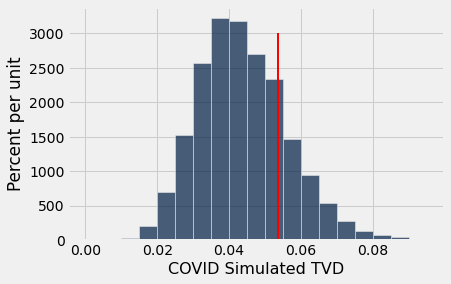

In [17]:
COVID_bins = np.arange(0, 0.10, 0.005)

Table().with_column('COVID Simulated TVD', COVID_simulated_tvds).hist(0, bins = COVID_bins)
plots.plot([COVID_observed_tvd, COVID_observed_tvd], [0, 30], color='red', lw=2);

In [18]:
p_value = np.count_nonzero(COVID_simulated_tvds >= COVID_observed_tvd) / num_trials
p_value

0.2085

## Step 4. The Conclusion of the Test

The choice between the null and alternative hypotheses depends on the comparison between what you computed in Steps 2 and 3: the observed value of the test statistic and its distribution as predicted by the null hypothesis.

- By our convention and using a p-value cut-off of 5%, the p-value we computed above is considered large. It is bigger than the 5%. 

- So the conventional conclusion would be to FAIL TO REJECT the null hypothesis. Formally, we say that `the result of the test is NOT statistically significant.`

- That is, we do not have sufficient evidence to state that Chinese reported data DO NOT match the distribution expected in Benford's law. 

#  New Topic: Comparing Two Samples

In all of these cases we have considered before now, there was just one random sample, and we were trying to decide how the proportions of two or more categories of attributes had been generated. But often, data scientists have to compare two random samples with each other.

In this class, we develop a way of using Python to compare two random samples and answer questions about the similarities and differences between them. You will see that the methods we develop have diverse applications.

Context of the problem

- A large Statistics class is divided into 12 lab sections.
- Garduate Instructional Assistants lead the labs.
- After the midterm, students in lab section 3 notice that the average score for the students in lab section 3 is lower than in others

Research Question: Is the difference due to chance OR some other factor other than chance(statistically significant)?


In [19]:
# Load the data set.

scores = Table.read_table('scores_by_section.csv')
scores

Section,Midterm
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


### Some Descriptive Statistics of the Data Set

Create a summary table of:

- how many students there are in each lab section.
- the average score of students by lab section.

In [20]:
# how many students there are in each lab section?

scores.group('Section')

Section,count
1,32
2,32
3,27
4,30
5,33
6,32
7,24
8,29
9,30
10,34


In [21]:
# What is the the average score of students by lab section?

average_score_by_section = scores.group('Section', np.average)
average_score_by_section

Section,Midterm average
1,15.5938
2,15.125
3,13.6667
4,14.7667
5,17.4545
6,15.0312
7,16.625
8,16.3103
9,14.5667
10,15.2353


## Step 1: Setting up the null and alternative hypotheses for this application problem:

**The null hypothesis:** If we had picked my section at random from the whole class, we could have got an average like the one observed for lab section 3.


**The alternative hypothesis:** No, the average score for lab section 3 is too low. Chance/Randomness is not the only reason for the low scores.


## Step 2: Define The Test Statistic and Compute the Observed Value of the Test Statistic

The model says the average of any lab section is NOT different from what was obseved for lab section 3. The alternative viewpoint is that the average score observed for section is statistically and significantly differen from what was observed for lab section 3. 

Based on this context and what we appear to be keepping track of, a natural statistic is this example is the average score of a lab section. 

- Values close to the average observed for lab section 3 will favor the null hypothesis.

In [22]:
observed_average = average_score_by_section.where('Section', 3).column('Midterm average').item(0)
observed_average

13.666666666666666

## Step 3: The Distribution of the Test Statistic, Under the Null Hypothesis

- We can simulate data based on the assumption that the model stated in the null hypothesis is true.

- That is, we can simulate drawing ANY section of sample size 27 at random from a population of all sections to observe what the average score will be.

In [23]:
random_sample = scores.sample(27, with_replacement=False)
random_sample

Section,Midterm
7,12
8,8
4,15
11,11
2,5
8,18
6,11
5,13
8,16
7,10


In [24]:
np.average(random_sample.column('Midterm'))

13.333333333333334

In [25]:
# Simulate one value of the test statistic 
# under the hypothesis that the section is like a random sample from the class

def random_sample_midterm_avg():
    random_sample = scores.sample(27, with_replacement = False)
    return np.average(random_sample.column('Midterm'))

In [26]:
# Simulate 10,000 copies of the test statistic

sample_averages = make_array()

for i in np.arange(10000):
    sample_averages = np.append(sample_averages, random_sample_midterm_avg())    

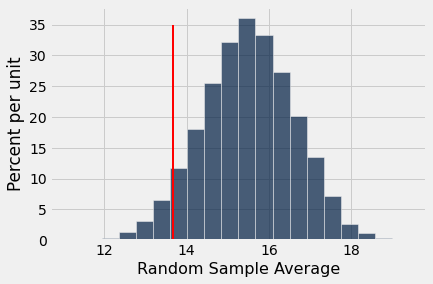

In [27]:
# Compare the simulated distribution of the statistic
# and the actual observed statistic

averages_tbl = Table().with_column('Random Sample Average', sample_averages)
averages_tbl.hist(bins = 20)
plots.plot([observed_average, observed_average], [0, .35], color='red', lw=2);

In [28]:
p_value = np.count_nonzero(sample_averages <= observed_average) / 10000
p_value

0.0547

## Step 4. The Conclusion of the Test

The p-value of a test is the chance, based on the model in the null hypothesis, that the test statistic will be equal to the observed value in the sample or even further in the direction that supports the alternative.

IN GENERAL, this is a reminder that a hypothesis test has only two possible conclusions:

- Reject the Null Hypothesis:
        - p-value is small(smaller than the chosen p-value cutoff)
        - the tail beyond the observed statistic is small, so the observed statistic is far away from what the null predicts. 
        - This implies that the data support the alternative hypothesis better than they support the null.
        
- Fail to reject the Null Hypothesis:
        - p-value is not small(or larger than the p-value cut-off)
        - the tail beyond the observed statistic is not small, so the observed statistic is not far away from what the null predicts.
        - This implies that the data does not support the alternative hypothesis better than they support the null.


IN THIS EXAMPLE, since the p-value above is larger than a chosen p-value cut-off of 0.05, we FAIL TO REJECT the null hypothesis. This means that the hypothesis testing analysis lends support to the realization that the the data does not support the alternative hypothesis better than they support the null.

Formally, we say that `the result of the test is NOT statistically significant.` 

In the context of this problem, we fail to reject the claim that if we had picked my section at random from the whole class, we could have got an average like the one observed for lab section 3.